Download the simplicial kuramoto package from https://github.com/arnaudon/simplicial-kuramoto
Then install it locally (python setup.py install) 

In [1]:
import numpy as np
import networkx as nx

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.frustration_scan import scan_frustration_parameters

G = nx.Graph()
G.add_edge(0, 1, weight=1, edge_com=0)
G.add_edge(1, 2, weight=1, edge_com=0)
G.add_edge(2, 0, weight=1, edge_com=0)

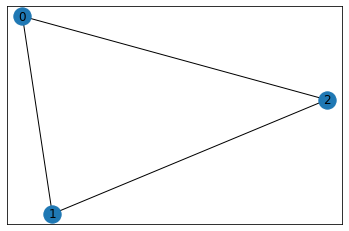

In [2]:
nx.draw_networkx(G)

In [3]:
Gsc = SimplicialComplex(graph=G)
Gsc.flip_edge_orientation([0, 1])

In [14]:
alpha1 = np.linspace(0, 2.5, 10)
alpha2 = np.linspace(0, np.pi / 2.0, 20)
n_repeats = 1
t_max = 500
n_t = 1000
n_workers = 6

res = scan_frustration_parameters(
    Gsc,
    filename="triangle.pkl",
    alpha1=alpha1,
    alpha2=alpha2,
    repeats=n_repeats,
    n_workers=n_workers,
    t_max=t_max,
    n_t=n_t,
)

100%|██████████| 200/200 [01:45<00:00,  1.89it/s]


In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.integrators import integrate_edge_kuramoto
from simplicial_kuramoto.frustration_scan import get_projection_fit


def plot_phase_traj(Gsc, alpha_1, alpha_2, folder=".", t_max=50, min_s=1.0):

    np.random.seed(42)
    initial_phase = np.random.random(Gsc.n_edges)

    n_t = 1000
    n_min = 100

    res = integrate_edge_kuramoto(
        Gsc,
        initial_phase,
        t_max,
        n_t,
        alpha_1=alpha_1,
        alpha_2=alpha_2,
    )
    result = res.y[:, n_min:]
    time = res.t[n_min:]

    grad, curl, harm, grad_slope, curl_slope, harm_slope = get_projection_fit(
        Gsc, res, n_min=n_min
    )

    print(f"grad slope = {grad_slope}, curl slope = {curl_slope}")

    plt.figure(figsize=(3, 3))

    plt.plot(np.sin(result[0]), np.sin(result[2]), "-k")
    plt.plot(np.sin(result[0, ::15]), np.sin(result[2, ::15]), "k.")
    plt.axis([-1.01, 1.01, -1.01, 1.01])
    plt.axis("equal")
    plt.suptitle(f"alpha_1 = {alpha_1}, alpha2 = {alpha_2}")
    plt.savefig(
        f"{folder}/traj_a1_{np.round(alpha_1, 5)}_a2_{np.round(alpha_2, 3)}.pdf",
        bbox_inches="tight",
    )
    plt.close()

    grad, curl, harm, grad_slope, curl_slope, harm_slope = get_projection_fit(Gsc, res, n_min=0)
    time = res.t
    plt.figure(figsize=(4, 3))
    plt.plot(time, grad, label="grad")
    plt.plot(time, grad_slope[1] + time * grad_slope[0], c="k", ls="--")
    plt.plot(time, curl, label="curl")
    plt.plot(time, curl_slope[1] + time * curl_slope[0], c="k", ls="--")
    plt.xlabel("time")
    plt.ylabel("projection")
    plt.gca().set_xlim(time[0], time[-1])
    plt.legend(loc="best")
    plt.suptitle(f"alpha_1 = {alpha_1}, alpha2 = {alpha_2}")
    plt.savefig(
        f"{folder}/proj_a1_{np.round(alpha_1, 5)}_a2_{np.round(alpha_2, 3)}.pdf",
        bbox_inches="tight",
    )
    plt.close()


def plot_2_phase_traj(Gsc, alphas_1, alpha_2, folder="figures_traj", t_maxs=50, min_s=1.0):

    np.random.seed(42)
    initial_phase = np.random.random(Gsc.n_edges)

    n_t = 1000
    n_min = 100

    plt.figure(figsize=(4, 3))
    results = []
    for c, alpha_1, t_max in zip(["C0", "C1"], alphas_1, t_maxs):
        res = integrate_edge_kuramoto(
            Gsc,
            initial_phase,
            t_max,
            n_t,
            alpha_1=alpha_1,
            alpha_2=alpha_2,
        )
        results.append(res.y[:, n_min:])
        time = res.t[n_min:]

        grad, curl, harm, grad_slope, curl_slope, harm_slope = get_projection_fit(
            Gsc, res, n_min=n_min
        )

        plt.plot(time, grad, label="grad", c=c, ls="--")
        plt.plot(time, curl, label="curl", c=c)

    plt.xlabel("time")
    plt.ylabel("projection")
    plt.gca().set_xlim(time[0], time[-1])
    plt.legend(loc="best")
    plt.suptitle(f"alpha_1 = {alpha_1}, alpha2 = {alpha_2}")
    plt.savefig(f"{folder}/proj_transition.pdf", bbox_inches="tight")
    plt.close()

    plt.figure(figsize=(3, 3))
    for c, result in zip(["C0", "C1"], results):
        if c == "C0":
            plt.plot(np.sin(result[0]), np.sin(result[2]), "-", c=c)
        else:
            plt.plot(np.sin(result[0]), np.sin(result[2]), "--", c=c)
        plt.plot(np.sin(result[0, ::15]), np.sin(result[2, ::15]), ".", c=c)

    plt.axis([-1.01, 1.01, -1.01, 1.01])
    plt.axis("equal")
    plt.savefig(f"{folder}/traj_transition.pdf", bbox_inches="tight")
    plt.close()

In [9]:
G = nx.Graph()
G.add_edge(0, 1, weight=1, edge_com=0)
G.add_edge(1, 2, weight=1, edge_com=0)
G.add_edge(2, 0, weight=1, edge_com=0)

Gsc = SimplicialComplex(graph=G, faces=[[1, 0, 2]])
Gsc.flip_edge_orientation([0, 1])

alphas_1 = [1.1939, 1.19395]
t_maxs = [34.5, 34.5]
alpha_2 = 1.5
plot_2_phase_traj(Gsc, alphas_1, alpha_2, t_maxs=t_maxs, min_s=5, folder=".")

alpha_1 = 1.1
alpha_2 = 1.5
plot_phase_traj(Gsc, alpha_1, alpha_2, t_max=60)

alpha_1 = 1.2
alpha_2 = 1.5
plot_phase_traj(Gsc, alpha_1, alpha_2, t_max=40)

alpha_1 = 2.0
alpha_2 = 0.2
plot_phase_traj(Gsc, alpha_1, alpha_2, t_max=18, min_s=5)

100%|█████████▉| 999/1000 [00:00<00:00, 2962.11it/s]


grad slope = [-4.64169438e-05  3.14165304e-01], curl slope = [ 0.23637215 -1.47798868]


100%|██████████| 1000/1000 [00:00<00:00, 2722.33it/s]


grad slope = [ 0.51369464 -2.51129052], curl slope = [ 0.36633615 -1.42683123]


100%|█████████▉| 999/1000 [00:00<00:00, 3338.28it/s]


grad slope = [ 1.75852274 -1.34067048], curl slope = [1.51361801e-04 3.89796412e-01]


100%|██████████| 200/200 [00:01<00:00, 110.88it/s]


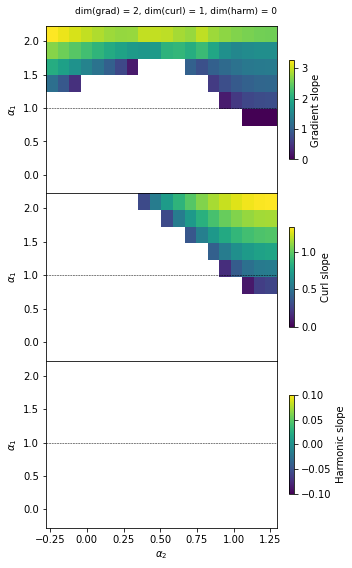

In [15]:
from simplicial_kuramoto.frustration_scan import plot_projections, plot_order


path = "results/triangle.pkl"

plot_projections(path, "projections.pdf")
# plot_order(path, "order.pdf")



In [16]:
# larger SC

100%|██████████| 20/20 [06:52<00:00, 20.61s/it]


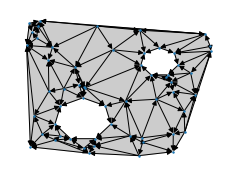

In [20]:
"""Scan frustration parameter."""
import numpy as np
from simplicial_kuramoto.frustration_scan import scan_frustration_parameters

from simplicial_kuramoto.graph_generator import delaunay_with_holes
from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.plotting import draw_simplicial_complex


np.random.seed(42)

t_max = 1000
n_t = 500
n_workers = 6
repeats = 2
n_alpha2 = 20

centres = [[0.3, 0.3], [0.7, 0.7]]
radii = [0.15, 0.1]

graph, points = delaunay_with_holes(50, centres, radii, n_nodes_hole=7)
Gsc = SimplicialComplex(graph=graph)
draw_simplicial_complex(Gsc, filename="larger_graph.pdf", with_labels=False)

res = scan_frustration_parameters(
    Gsc,
    folder=".",
    filename="complex.pkl",
    alpha1=[0.0],
    alpha2=np.linspace(0, np.pi / 2.0, n_alpha2),
    repeats=repeats,
    n_workers=n_workers,
    t_max=t_max,
    n_t=n_t,
    harmonic=True,
)


In [27]:
import pickle as pk
pk.dump([Gsc, res, alpha1, alpha2], open('./complex.pkl', 'wb'))

100%|██████████| 20/20 [00:01<00:00, 14.44it/s]


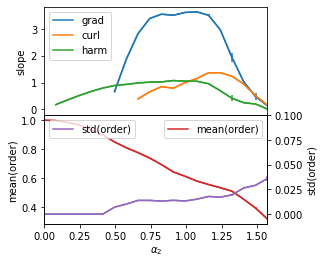

In [28]:
from simplicial_kuramoto.frustration_scan import plot_order_1d

plot_order_1d(path="./complex.pkl", filename="scan_graph_larger.pdf", with_std=True)
